## Melhorando entendimento e acertos dos `datasets`

Neste notebook será apresentado algumas tarefas úteis que podem melhorar o entendimento do que é um "sinal bom" comparado a ruídos de dados em dados `SSVEP`.

Além disso, será listado uma série de melhorias que vão desde a etapa de extração de características até a classificação dos dados. Conhecemos estas melhorias como *tunning*.

### Visualização gráfica do sinal SSVEP

Para visualização do sinal SSVEP, vamos filtrar apenas o tempo em que houve estímulos para o `BETA dataset`.

### Melhoramentos das etapas de classificação

#### Extração de características

Basicamente, para levantamento das características, levamos em consideração apenas duas: `narrow-band SNR` e `wide-band SNR`. Vamos também adicionar duas outras características em cima dos dados estimulados no domínio da frequência (`FFT`): (1) amplitude dos targets e (2) média dos valores centrais dos targets.

Para cada característica estima-se que tenhamos a seguinte matriz: (160, 64, 40). Como teremos 4 características, a matriz final ficará com a seguinte dimensionalidade: (160, 64, 160) $\rightarrow$ (160, 10240).

**Observação**: Como os targets estão muito próximos um do outro, é possível que não tenha mais de um valor para calcular a média. Desta forma, será possível obter apenas a característica de "maior valor" ou amplitude do sinal no domínio da frequência.

#### Seleção de características

Nesta etapa, são selecionadas as características que mais afetam positivamente no resultado final da classificação. Segue uma lista de métodos de seleção de características nesta [página do projeto sklearn](https://scikit-learn.org/stable/modules/feature_selection.html).

Seria interessante mostrar o resultado para os dados do trabalho, para os seguintes métodos de seleção de características:
- `VarianceThreshold`
- `Univariate feature selection`
    - escolha o que mais for "interessante": `SelectKBest`, `SelectPercentile` e `GenericUnivariateSelect`
- `Recursive feature elimination (RFE)`

#### Classificação e rotulação dos X

Com as atividades anteriores já realizadas, é possível aplicarmos um classificador simples para testarmos os X. O classificador `SVM` (*Support Vector Machine*) pode nos mostrar bons resultados (se levarmos em consideração trabalhos relacionados da área).

Após a primeira impressão do classificador, já é possível revisitarmos passos anteriores para alterá-los, a fim de buscar melhores resultados de acurácia do classificador. Sugere que este seja um primeiro desafio após a implementação do classificador.

Outros passos interessantes incluem dividir os X em diversos *folds*. Para isso pode ser utilizado o método [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)

Inicialmente, temos que desenvolver o vetor de rótulos que está relacionado com os nossos dados.

#### Visualização dos dados

Para verificar o estímulo SSVEP ocorrendo, sugere plotar os dados no momento correto em que há este estímulo (0,5 - 2,5 segundos para os 15 primeiros participantes)

In [1]:
from scipy.io import loadmat
import numpy as np

last_group = list()
for i in range(61, 71):
    last_group.append(loadmat(f"/home/rhubner/Downloads/S61-S70/S{i}.mat")['data'])

# informações iguais para todos os grupos
info = last_group[-1]

In [2]:
# 0-sub, 1-age, 2-gender, 3-chan, 
# 4-freqs, 5-phases, 6-bci_quotient,
# 7-wide_snr, 8-narrow_snr, 9-srate

eeg_data = np.array([d[0][0][0] for d in last_group])
data = info[0][0][1][0][0]

chs = [d[3][0] for d in data[3]]
labels = data[4][0]
eeg = eeg_data.transpose(0, 4, 3, 1, 2)

print(len(chs), chs)
print(labels.shape, labels)
print(eeg.shape)

64 ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2']
(40,) [ 8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2
 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.
 14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8  8.   8.2  8.4]
(10, 40, 4, 64, 1000)


In [3]:
# média dos 10 últimos participantes
eeg1 = np.average(eeg, axis=0)
print(eeg1.shape)

# média dos 4 blocos
eeg2 = np.average(eeg1, axis=1)
print(eeg2.shape)

# separando os eletrodos entendidos como "bons": Pz, PO3, PO5, PO4, PO6, POz, 
# O1, Oz e O2.
print([(i, ch) for i, ch in enumerate(chs)])
eeg3 = eeg2[:, [47, 54, 53, 56, 57, 55, 60, 61, 62], :]
print(eeg3.shape)

# média dos 9 eletrodos escolhidos
eeg4 = np.average(eeg3, axis=1)
print(eeg4.shape)

# dados sem a parte basal
X = eeg4[:, 125:-125]
print(X.shape)

(40, 4, 64, 1000)
(40, 64, 1000)
[(0, 'FP1'), (1, 'FPZ'), (2, 'FP2'), (3, 'AF3'), (4, 'AF4'), (5, 'F7'), (6, 'F5'), (7, 'F3'), (8, 'F1'), (9, 'FZ'), (10, 'F2'), (11, 'F4'), (12, 'F6'), (13, 'F8'), (14, 'FT7'), (15, 'FC5'), (16, 'FC3'), (17, 'FC1'), (18, 'FCZ'), (19, 'FC2'), (20, 'FC4'), (21, 'FC6'), (22, 'FT8'), (23, 'T7'), (24, 'C5'), (25, 'C3'), (26, 'C1'), (27, 'CZ'), (28, 'C2'), (29, 'C4'), (30, 'C6'), (31, 'T8'), (32, 'M1'), (33, 'TP7'), (34, 'CP5'), (35, 'CP3'), (36, 'CP1'), (37, 'CPZ'), (38, 'CP2'), (39, 'CP4'), (40, 'CP6'), (41, 'TP8'), (42, 'M2'), (43, 'P7'), (44, 'P5'), (45, 'P3'), (46, 'P1'), (47, 'PZ'), (48, 'P2'), (49, 'P4'), (50, 'P6'), (51, 'P8'), (52, 'PO7'), (53, 'PO5'), (54, 'PO3'), (55, 'POZ'), (56, 'PO4'), (57, 'PO6'), (58, 'PO8'), (59, 'CB1'), (60, 'O1'), (61, 'OZ'), (62, 'O2'), (63, 'CB2')]
(40, 9, 1000)
(40, 1000)
(40, 750)


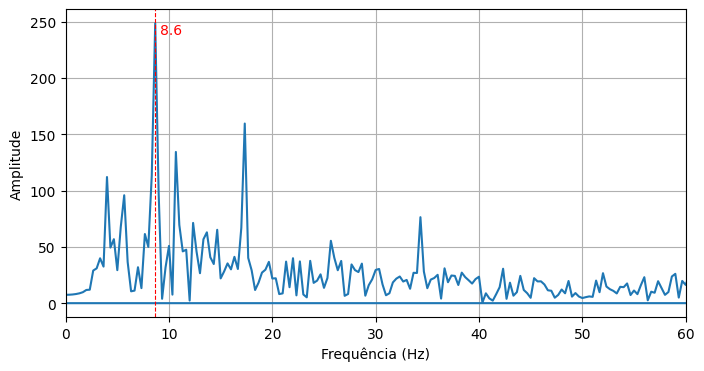

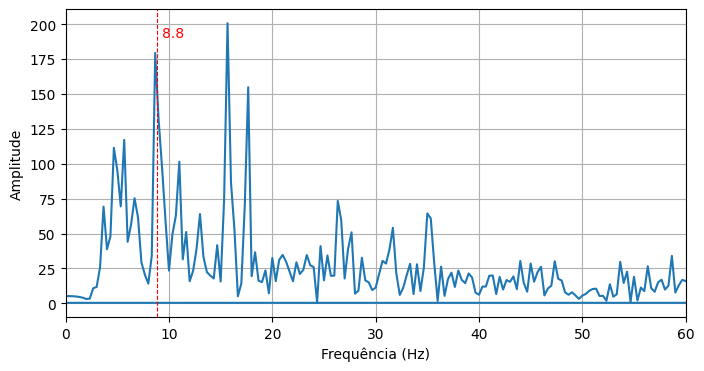

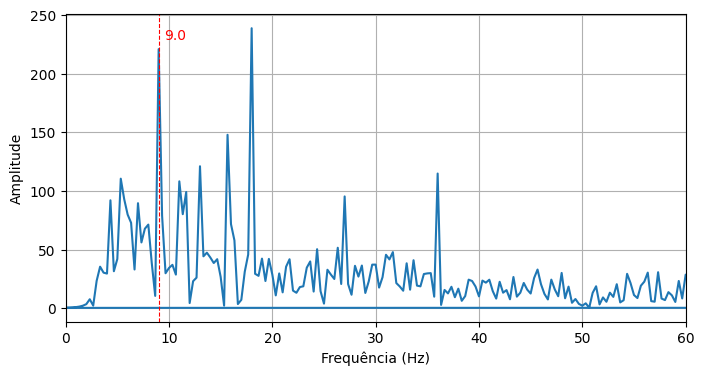

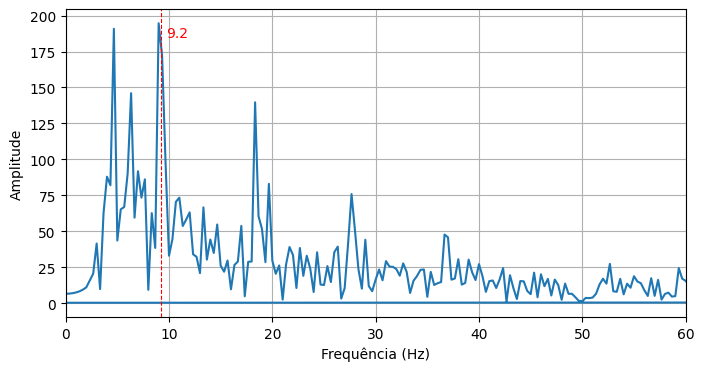

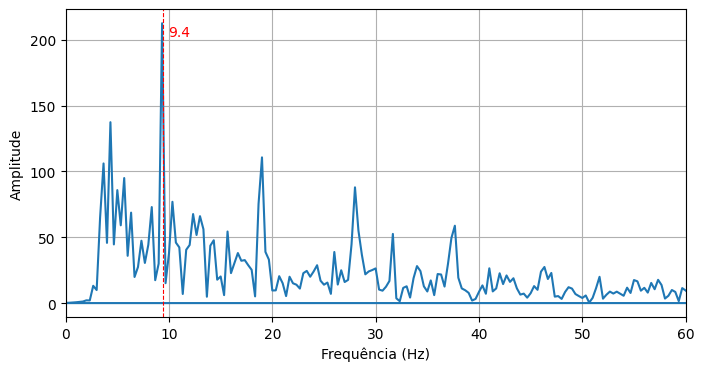

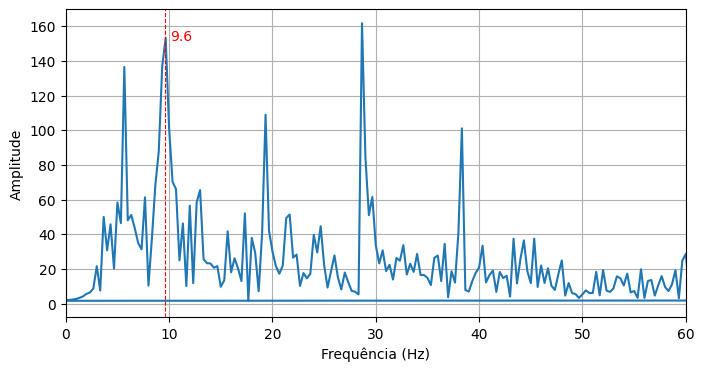

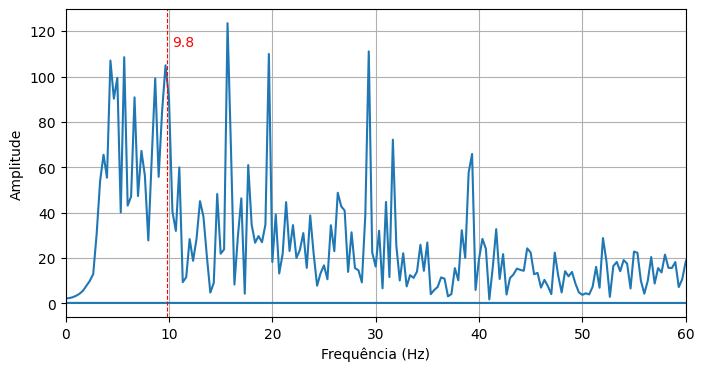

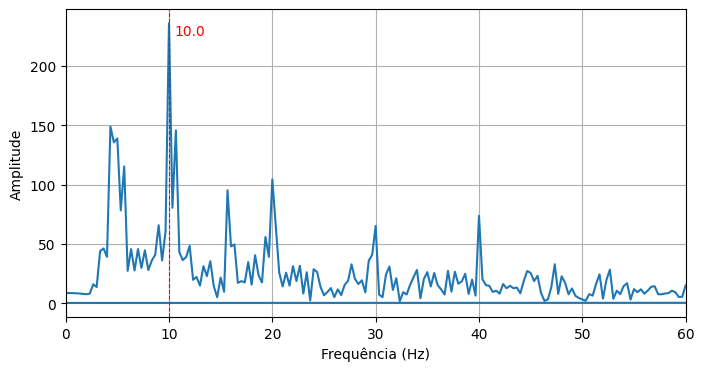

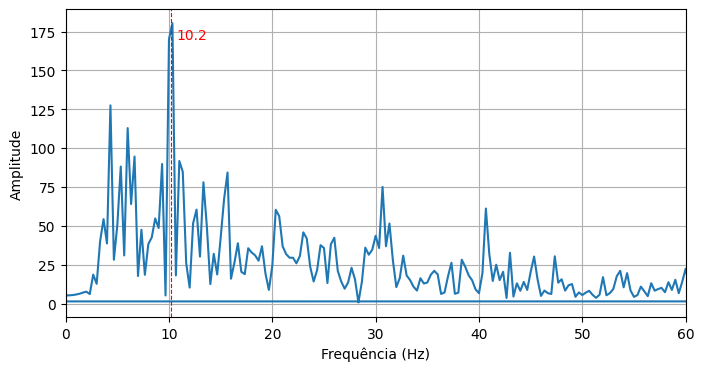

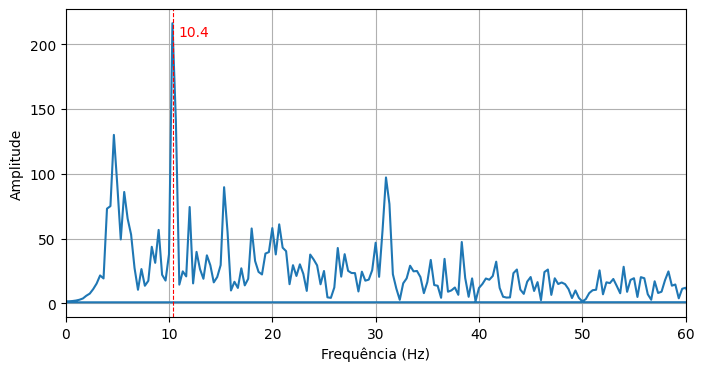

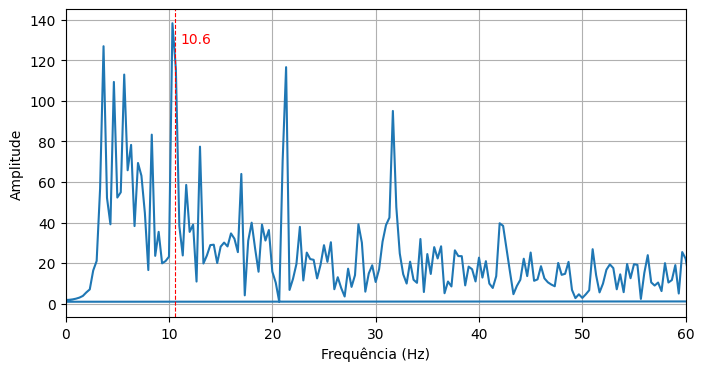

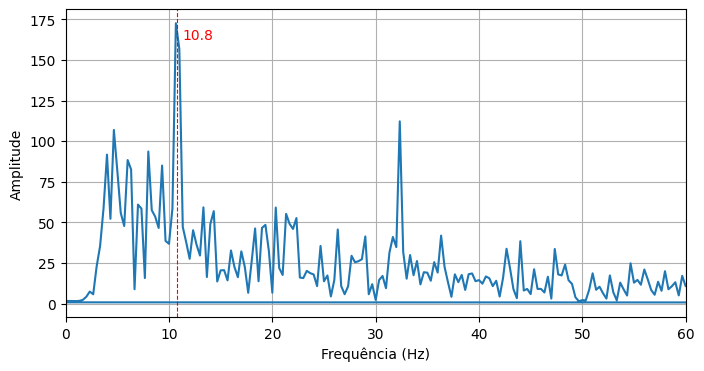

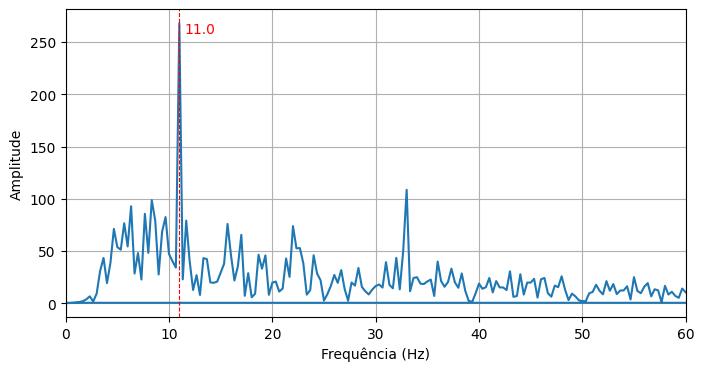

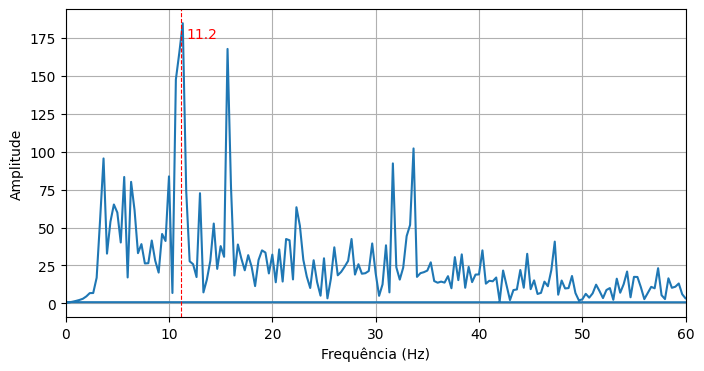

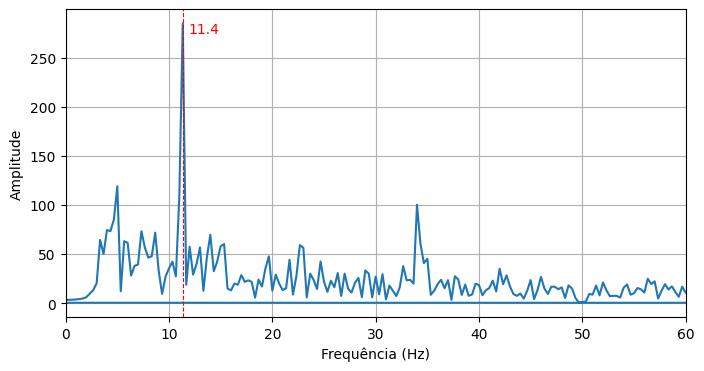

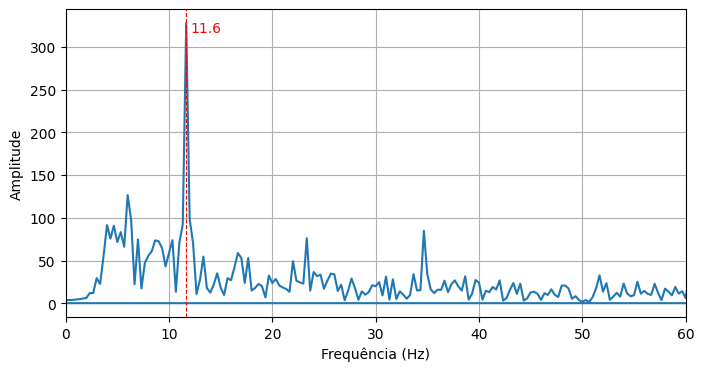

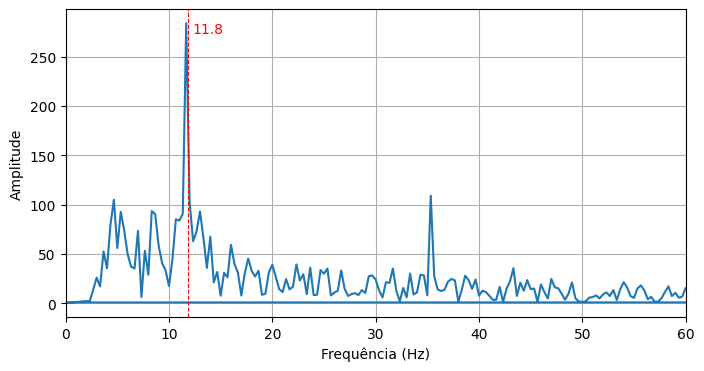

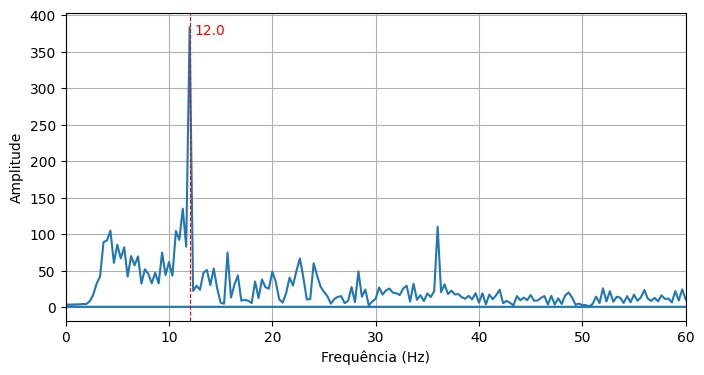

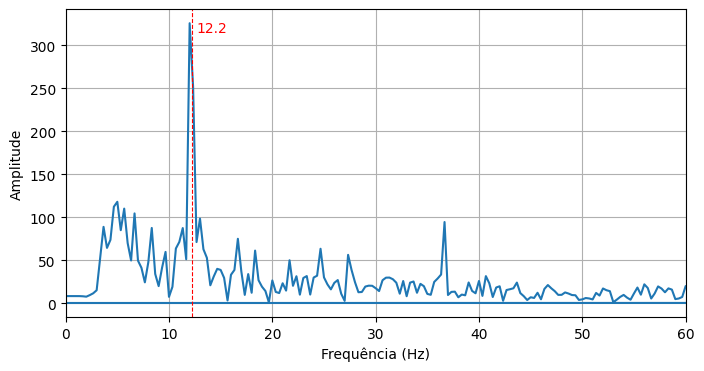

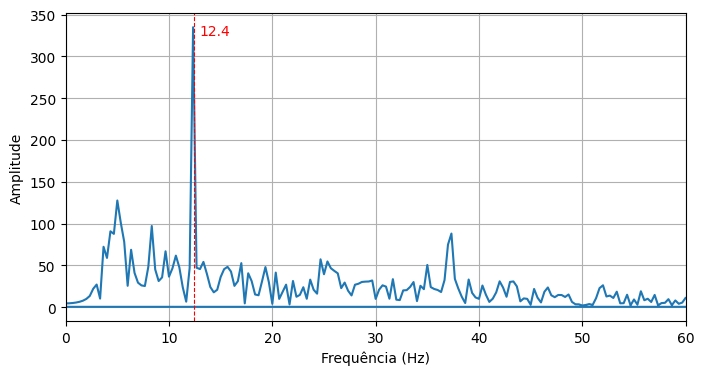

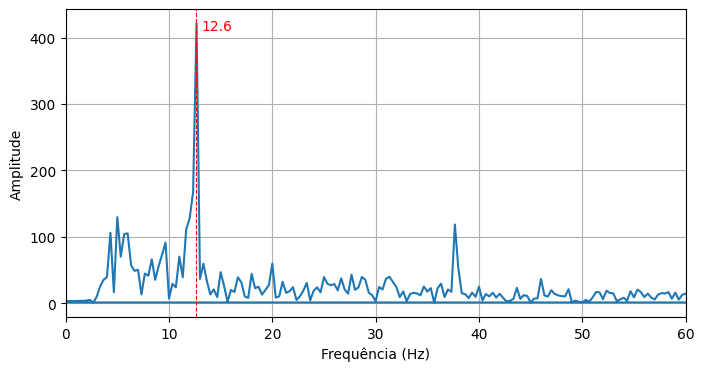

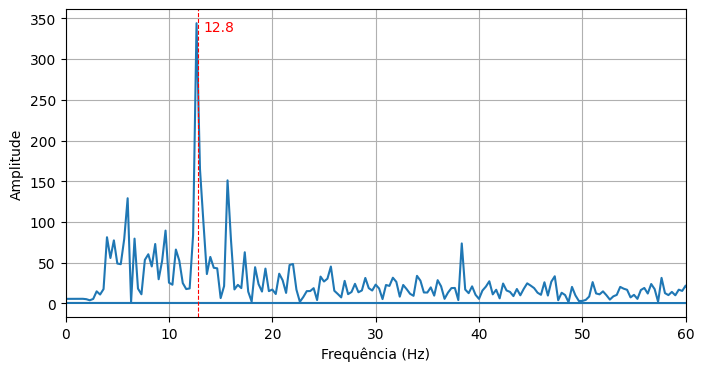

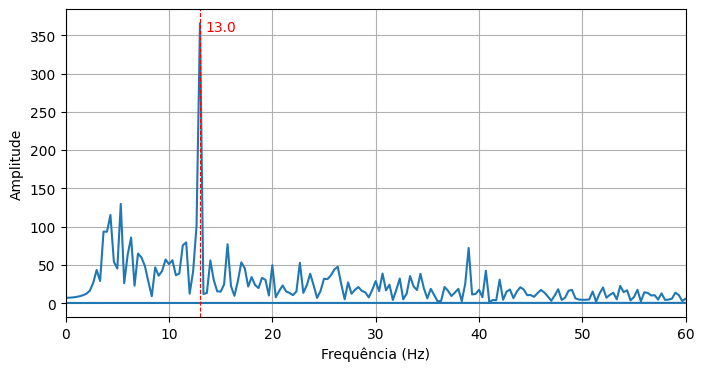

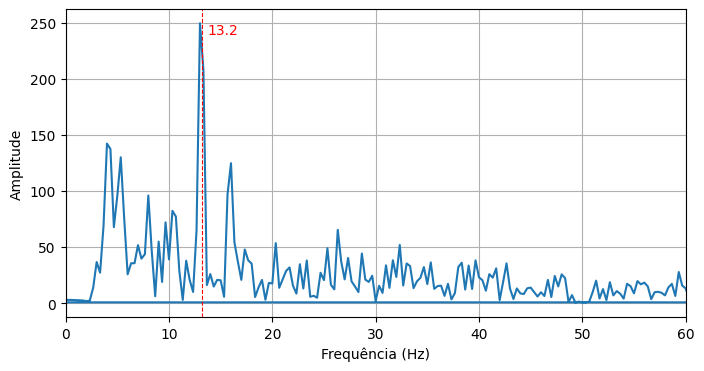

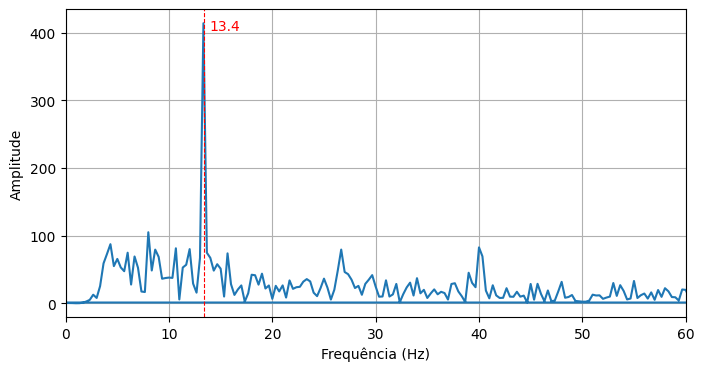

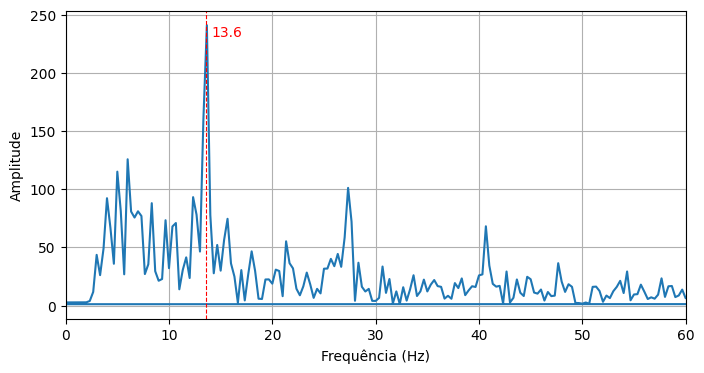

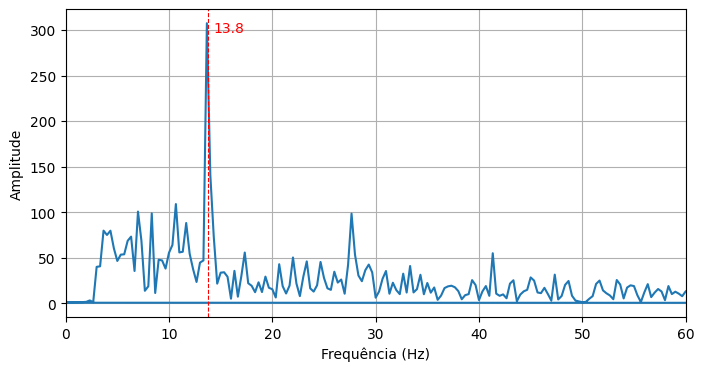

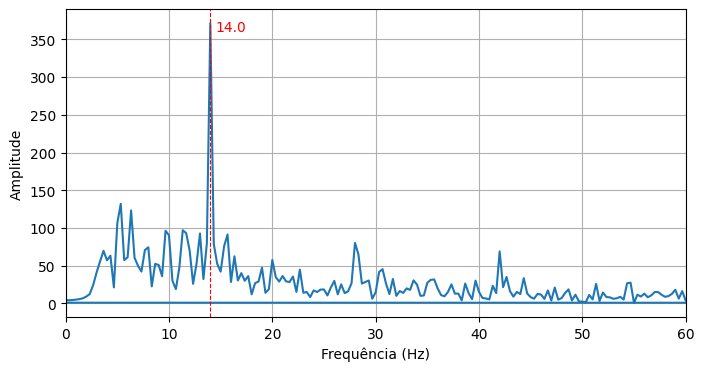

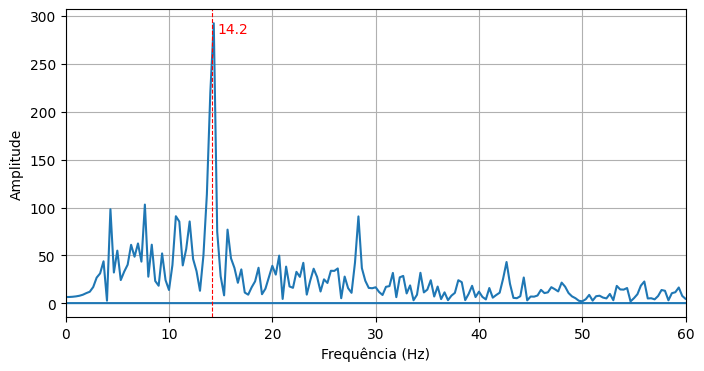

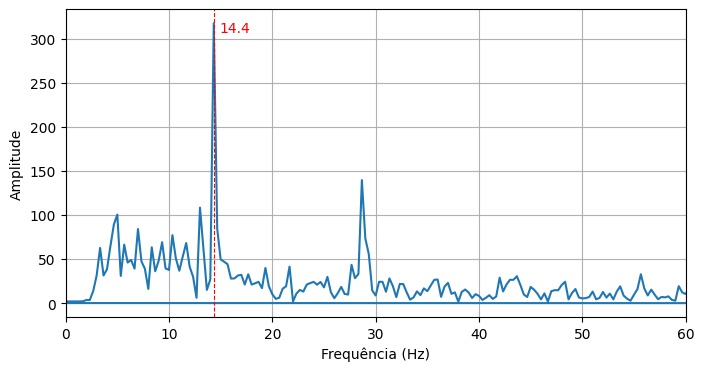

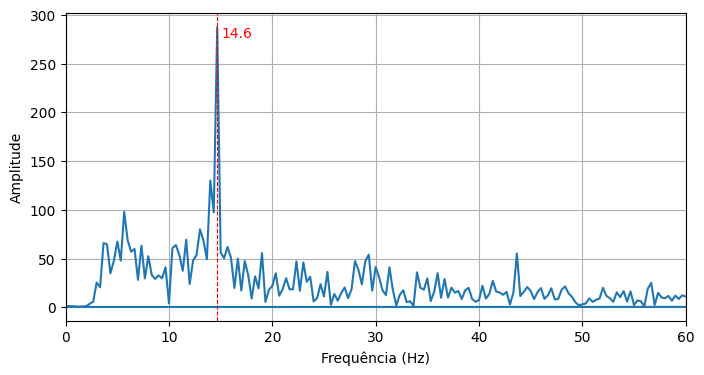

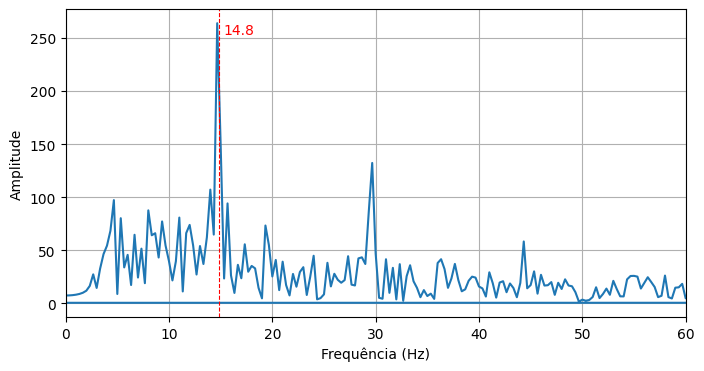

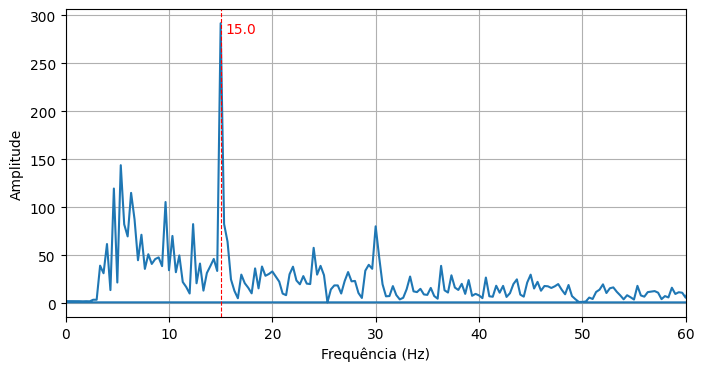

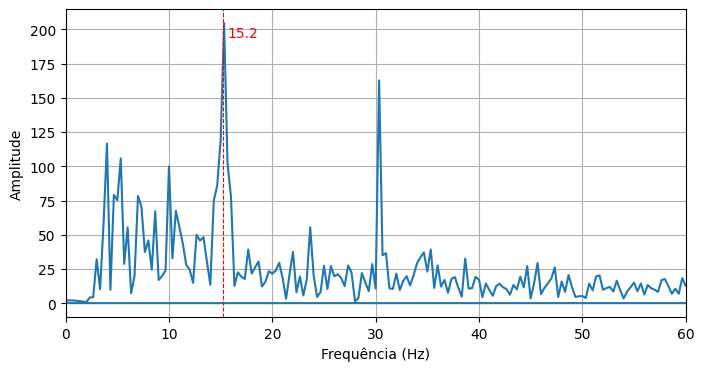

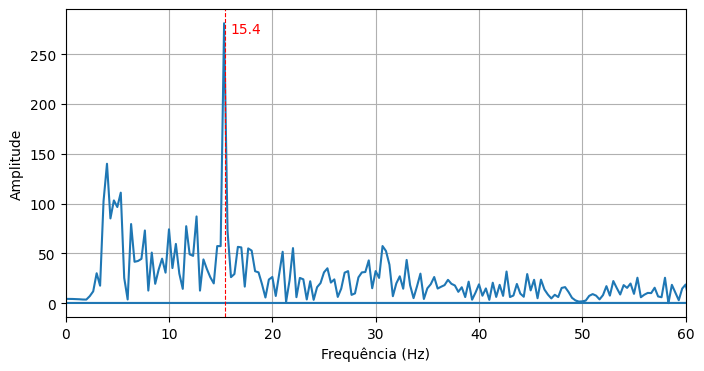

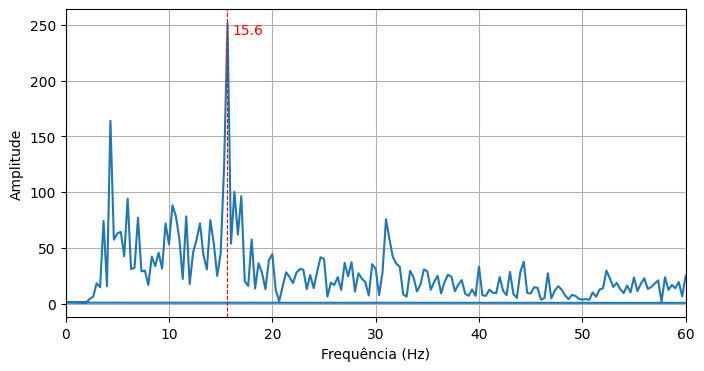

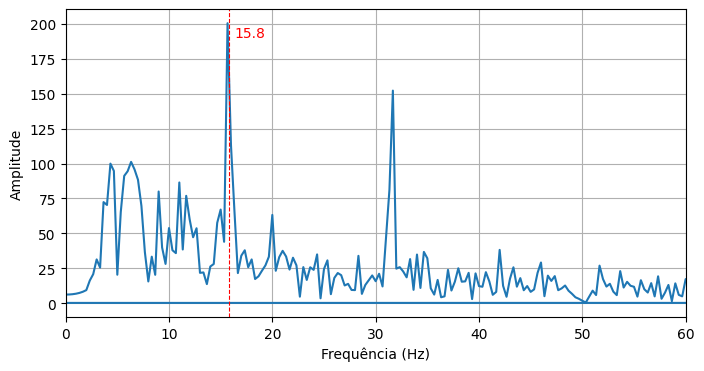

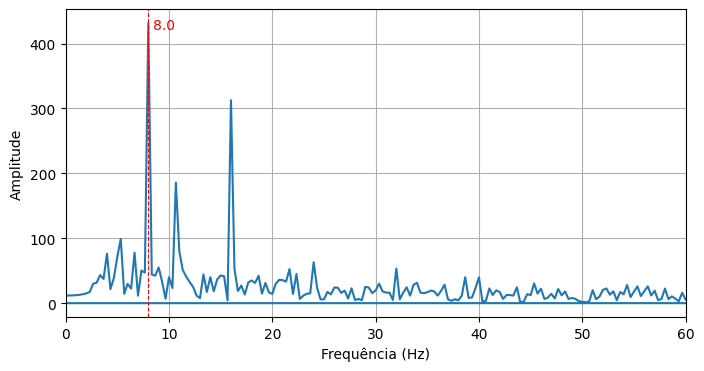

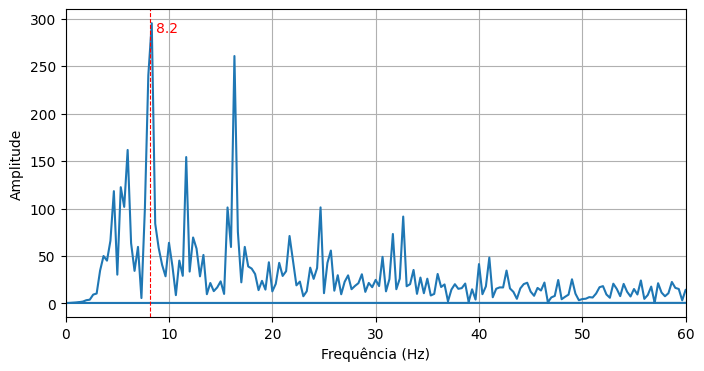

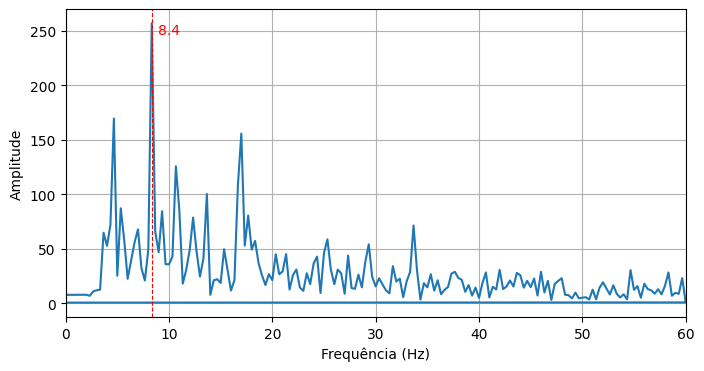

In [4]:
import matplotlib.pyplot as plt


for i in range(40):
    
    target = float(f"{labels[i]:.1f}")
    w = np.fft.fft(X, axis=1)
    freqs = np.fft.fftfreq(X.shape[1], (1 / 250))

    plt.figure(figsize=(8, 4))
    plt.plot(freqs, np.abs(w[i]))
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 60)
    plt.axvline(x=target, linestyle='--', linewidth=.8, color='red')
    plt.text(target + 0.5, np.max(np.abs(w[i]))-10, str(target), color='red')
    plt.grid()
    plt.show()